# Отчёт по тестовому заданию, выполнил Руслан Шерстюк

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

In [5]:
#Загрузим данные
df = pd.read_csv('data/data.tsv', sep='\t', header=None, names=['search_query', 'timestamp', 'device_type'])
df.head()

,search_query,timestamp,device_type
0,порно фото,1631786697,touch
1,малевич картины,1631806465,desktop
2,Секс,1631781583,touch
3,с днём рождения лена,1631771563,touch
4,зверополис порно,1631787599,touch


Данные можно получить и через sql, если загрузим в данную таблицу в например sqlite3 database. Перед этим импортируем в csv для упрощения загрузки данных. И таким же образом выполнять запросы

```bash
sqlite3 data.db
.mode csv
.import output.csv table_name
```

In [7]:
df.to_csv('output.csv', index=False)

In [14]:
query = "select * from data"

con = sqlite3.connect('data/data.db')

#Получение данных
datafatame = pd.read_sql(query, con)

#Закрыли соедеинение
con.close()

datafatame.head()

,search_query,timestamp,device_type
0,порно фото,1631786697,touch
1,малевич картины,1631806465,desktop
2,Секс,1631781583,touch
3,с днём рождения лена,1631771563,touch
4,зверополис порно,1631787599,touch


In [13]:
#Проверим данные на пропуски
df.isna().sum()

search_query    0
timestamp       0
device_type     0
dtype: int64

# Задание 1 
### *Укажите даты диапазона предоставленного вам для анализа.* 

Видим, что данные дат находятся во второй колонке, они в *unix timestampe* формате. Можем просто перевести их в формат дат в отдельную колонку *date* и посчиатем минимальную и максимальную соответственно, далее вычислим диапазон 

In [327]:
df['date'] = pd.to_datetime(df['timestamp'], unit = 's')

min_date = df['date'].min()
max_date = df['date'].max()

print(f"Временной диапазон данных: от {min_date} до {max_date}")

Временной диапазон данных: от 2021-08-31 21:00:00 до 2021-09-21 20:59:59


# Задание 2

### *Рассчитайте кол-во запросов с текстом "ютуб" в каждой платформе (desktop,touch)*

Сделаем маску с нужным нам значением *ютуб* и применим к нашему dataFrame. Видим, что с десктопов запросов больше, чем с мобильных устройств

In [328]:
mask = df['search_query'].str.contains(
    r'ютуб',
    case=False,
    na=False,
)

filtered_df = df[mask]


desktop_y = filtered_df[filtered_df['device_type'] == 'desktop']['search_query'].size

touch_y = filtered_df[filtered_df['device_type'] == 'touch']['search_query'].size

print(f"Колличество запросов с desktop - {desktop_y}")
print(f"Колличество запросов с touch - {touch_y}")

Колличество запросов с desktop - 806
Колличество запросов с touch - 732


Попробуем, расшить масску добави ругуляроне выражение. Видим, что всё также больше с декстопных устройств запросов больше.

In [329]:
mask = df['search_query'].str.contains(
    r'ютуб|ютьюб|youtube|ютюб',
    case=False,
    na=False,
    regex=True
)

filtered_df = df[mask]


desktop_y = filtered_df[filtered_df['device_type'] == 'desktop']['search_query'].size

touch_y = filtered_df[filtered_df['device_type'] == 'touch']['search_query'].size

print(f"Колличество запросов с desktop - {desktop_y}")
print(f"Колличество запросов с touch - {touch_y}")

Колличество запросов с desktop - 1668
Колличество запросов с touch - 894


# Задание 3

### *Выведите топ10 самых частотных запросов в каждой платформе (desktop,touch). Какие отличия вы видите?*

Сделаем новый *DataFrame* с данными о 10 самых популярных запросах в двух категорях *desktop,touch*

In [330]:
desktop_top = (
    df[df['device_type'] == 'desktop']
    ['search_query']
    .value_counts()
    .head(10)
    .rename_axis('Запрос')
    .reset_index(name='Количество')
)

touch_top = (
    df[df['device_type'] == 'touch']
    ['search_query']
    .value_counts()
    .head(10)
    .rename_axis('Запрос')
    .reset_index(name='Количество')
)


In [331]:
desktop_top

,Запрос,Количество
0,календарь 2021,2804
1,таблица менделеева,2631
2,картинки,1647
3,порно,1342
4,английский алфавит,1293
5,обои на рабочий стол,1143
6,Одноклассники (социальная сеть),1116
7,секс,895
8,таблица квадратов,877
9,алфавит,874


Видим, что чаще всего с декстопа ищут календарь, таблицу менделева и картинками.

In [332]:
touch_top

,Запрос,Количество
0,порно,7740
1,секс,6348
2,с днём рождения женщине,4903
3,с днём рождения,3967
4,с днём рождения мужчине,3623
5,хентай,3157
6,с днем рождения,3005
7,xxx,2429
8,Порно,2330
9,календарь 2021,2237


А вот с мобильными устройствами все проще, чаще всего пользователи заходят на категории *18+*, но есть и запросы на день рождения, вероятно, ищут слова поздравления или открытки

# Задание 4

### *Посмотрите, чем отличается трафик запросов в течении дня. Как можно объяснить отличие?*

In [333]:
df['hour'] = df['date'].dt.hour

trafic_by_hours = df.groupby('hour').size().reset_index(name='total_requests')

trafic_by_device = df.groupby(['hour', 'device_type']).size().unstack().fillna(0)


### Визуализация

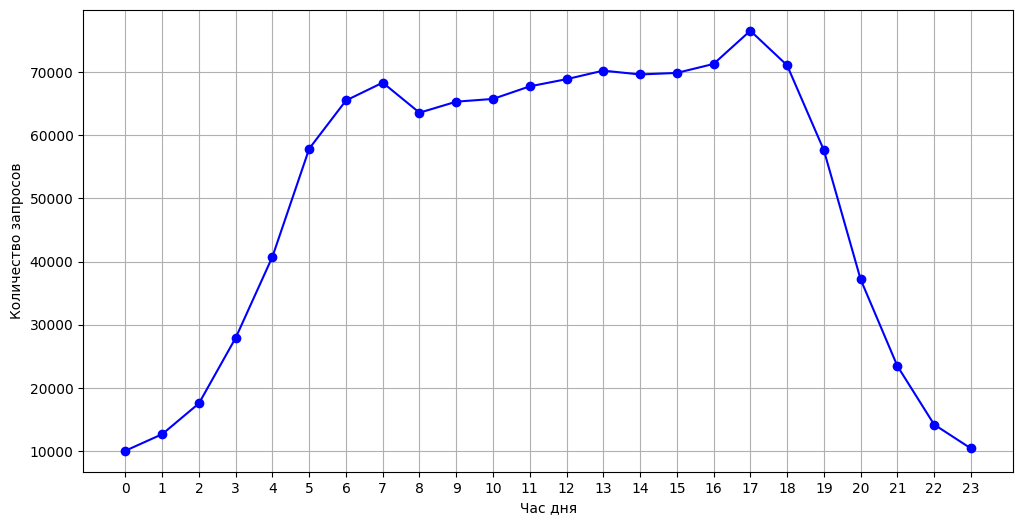

In [334]:
plt.figure(figsize=(12, 6))
plt.plot(trafic_by_hours['hour'], trafic_by_hours['total_requests'], marker='o', color='blue')
plt.xlabel('Час дня')
plt.ylabel('Количество запросов')
plt.xticks(range(24))
plt.grid(True)


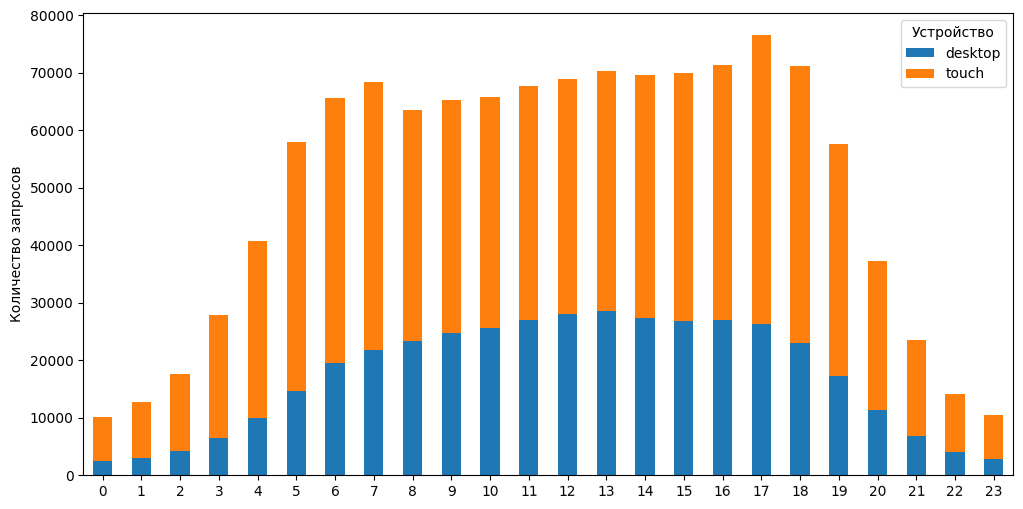

In [335]:
trafic_by_device.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('')
plt.ylabel('Количество запросов')
plt.xticks(range(24), rotation=1)
plt.legend(title='Устройство')

Проанализируем основные метрики: часы с максимальной нагрузкой, процент мобильного трафика

Видно, что есть два локальных максимума. Это утром в 7 часов и вечером в 17. Это нам можем говорить о том, что, вероятно, люди просываются заходят в интернет, делают запросы и делают запросы, когда идту домой с работы или уже приходят домой. Видно, что к ночи активность сильно уменьшается. В 20 часов она начинает резко падать, это, очевидно, связано с тем, что люди ложатся спать.

Также видно, что есть большое отличие по колличеству трафика с мобильных и декстопных устройств - с мобильных больше. А также стоит, что на десктопных устройствах нет пиков парактически, это нам говорит о том, что люди заходят утром и после работы вечером чаще с мобильных устройств. Доля мобильных устройств получилась равной 68.8%

In [336]:
peak_hour = trafic_by_hours.loc[trafic_by_hours['total_requests'].idxmax()]
peak_hours = trafic_by_hours.sort_values('total_requests', ascending=False)

local_peak_1 = peak_hours.iloc[0]
local_peak_2 = peak_hours.iloc[7]

print(f"""Локальные максимумы активности утром - в {local_peak_2['hour']} часов {local_peak_2['total_requests']} запросов 
      и вечером - в {local_peak_1['hour']} часов {local_peak_1['total_requests']} запросов""")

mobile_prcent = (trafic_by_device['touch'].sum() / df.shape[0]) * 100

print(f"Доля мобильных запросов: {mobile_prcent:.1f}%")


Локальные максимумы активности утром - в 7 часов 68364 запросов 
      и вечером - в 17 часов 76595 запросов
Доля мобильных запросов: 65.8%


# Задание 5

### *Выделите тематики запросов, контрастные для мобильных и компьютеров - темы, доля которых отличаются на разных платформах*

Для начала выделим основные категории запросов - погода, новости, игры и тд.


In [337]:
#Сделаем словарь категорий отдельно
categories = {
        'Погода': ['погода', 'яндекс погода'],
        'Новости': ['новости', 'сми', 'нвоость'],
        'Игры': ['игры', 'игра'],
        'Соцсети': ['vk', 'вк', 'фейсбук', 'facebook', 'WhatsApp', 'inst', 'instagram', 'инстаграм', 'однокласники'],
        'Работа': ['работа', 'вакансии', 'hh', 'хедхантер', 'headhunter'],
        'Музыка': ['музыка', 'яндекс музыка', 'vk музыка', 'spotify', 'спотифай'],
        'Фильмы': ['фильмы', 'кинопоиск'],
        'Шопинг': ['я маркет', 'ozon', 'wildberies', 'озон', 'вайлдберис'],
        '18+': ['порно', 'порнохаб', 'порнхаб', '18+', 'xxx', 'секс']
    }

#В функции пройдемся по словарю и будем итеративно разделять запросы по выделенным категорям, использую предикат any()
def categorize(query):
    query = query.lower()
    for category, keywords in categories.items():
        if any(kw in query for kw in keywords):
            return category 
    return 'Другое'

In [338]:
#Применим нашу функцию к выборке категорий
df['categiry'] = df['search_query'].apply(categorize)

In [339]:
#Посмотрим на уникальные категории, действительно ли все наши попали в занчения
df['categiry'].unique()

array(['18+', 'Другое', 'Соцсети', 'Фильмы', 'Игры', 'Погода', 'Музыка',
       'Новости', 'Работа', 'Шопинг'], dtype=object)

In [340]:
#Разделим наши данные по категориям в отдельные переменные
mobile_df = df[df['device_type'] == 'touch']
desktop_df = df[df['device_type'] == 'desktop']

In [341]:
#выделим две категории 
mobile_dist = (
    mobile_df['categiry'].value_counts(normalize=True)
    .mul(100)
    .round(4)
    .rename('mobile_%')
)



desktop_dist = (
    desktop_df['categiry'].value_counts(normalize=True)
    .mul(100)
    .round(4)
    .rename('desktop_%')
)

dist = pd.concat([mobile_dist, desktop_dist], axis=1)
dist

,mobile_%,desktop_%
categiry,,
Другое,92.7296,96.7480
18+,6.1648,1.5307
Соцсети,0.7789,1.2601
Погода,0.0976,0.0415
Игры,0.0908,0.2046
Фильмы,0.0640,0.0719
Новости,0.0255,0.0335
Музыка,0.0247,0.0595
Шопинг,0.0198,0.0384


In [342]:
#Добавим разность между процентным соотношением
dist['diff'] = (dist['mobile_%'] - dist['desktop_%']).abs()
dist

,mobile_%,desktop_%,diff
categiry,,,
Другое,92.7296,96.7480,4.0184
18+,6.1648,1.5307,4.6341
Соцсети,0.7789,1.2601,0.4812
Погода,0.0976,0.0415,0.0561
Игры,0.0908,0.2046,0.1138
Фильмы,0.0640,0.0719,0.0079
Новости,0.0255,0.0335,0.0080
Музыка,0.0247,0.0595,0.0348
Шопинг,0.0198,0.0384,0.0186


Видно, что подобрали ключевые слова досточно плохо (список самособой можно расширить и выборка будет более различима), но всё же категоризация есть и разница видна, исключим категорию *Другое* за неинформативностью. Посмотрим на графики распределения категорий по девайсам

### Визуализация

In [343]:
#Убрали категорию другое
dist_no_other = dist.drop('Другое', axis=0)

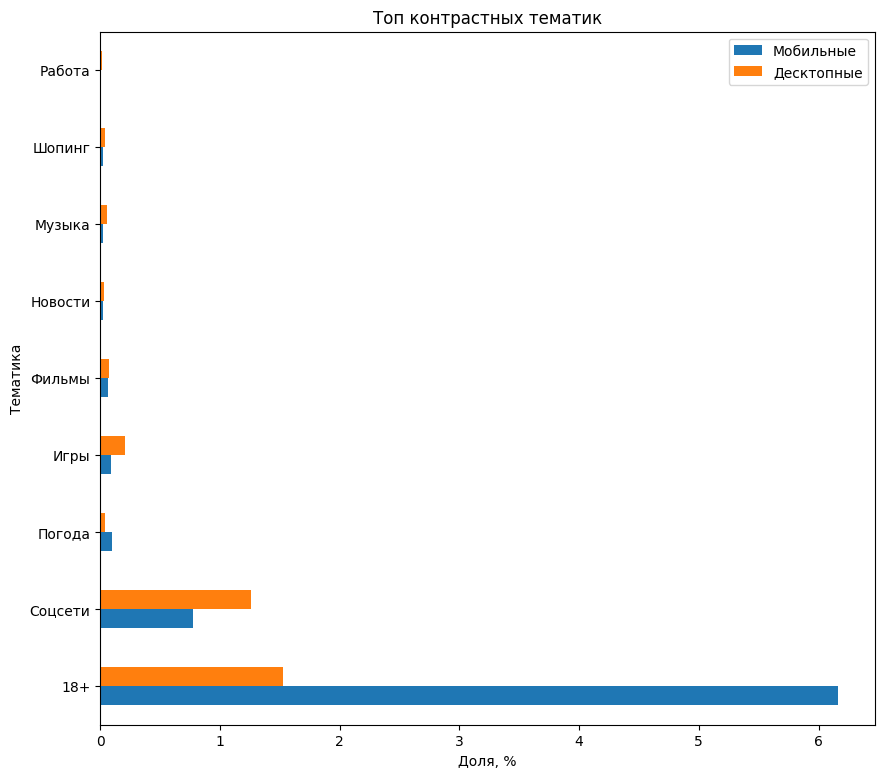

In [344]:
# dist.drop(dist['categiry']], axis=1, inplace=True)
dist_no_other[['mobile_%', 'desktop_%']].plot(
    kind='barh',
    figsize=(10,9),
    title="Топ контрастных тематик"
)
plt.xlabel('Доля, %')
plt.ylabel('Тематика')
plt.legend(['Мобильные', 'Десктопные'])

Видим, что для пользователей наиболее важна категория *18+*, можно заметить, что в ней сильно чаще используют мобильные устройства. В соцсети чаще заходят с десктопа, однако стоит учесть, что это связано с тем, что у меногих есть приложения социальных сетей на мобильных устройствах. Погоду чаще смотрят на мобльных устройствах. А вот в игры играю на десктопах


Посмотрим на график без большой категрии *18+*, чтобы увидеть разицу между другими категорями

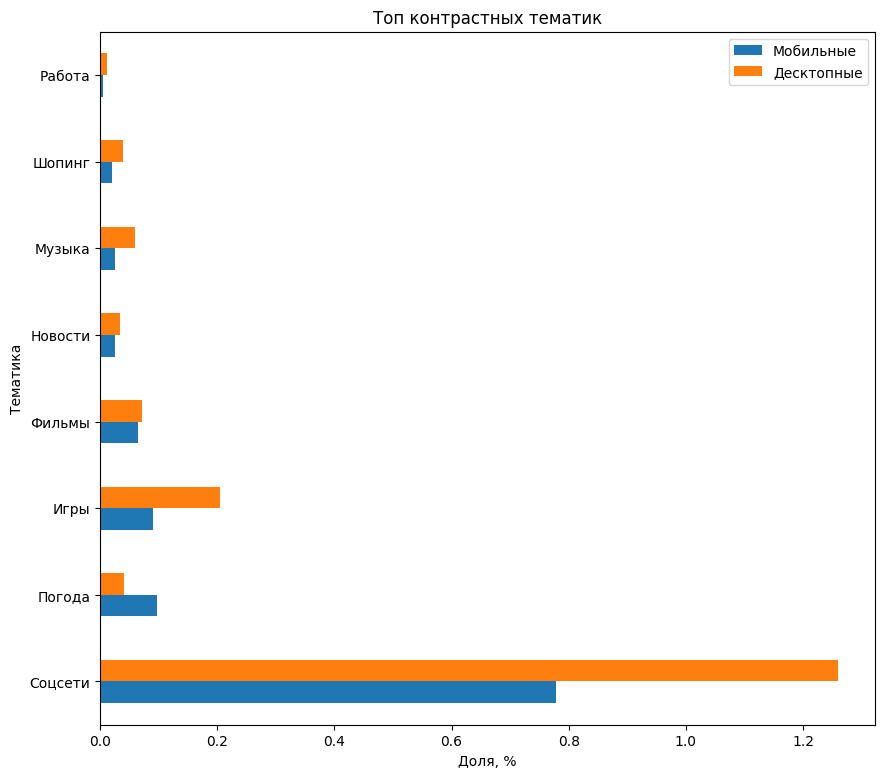

In [ ]:
dist_no_top_2 = dist.drop(['Другое', '18+'], axis=0)

dist_no_top_2[['mobile_%', 'desktop_%']].plot(
    kind='barh',
    figsize=(10,9),
    title="Топ контрастных тематик"
)
plt.xlabel('Доля, %')
plt.ylabel('Тематика')
plt.legend(['Мобильные', 'Десктопные'])

Тут можно заметить, что почти недеференцированы, однако всё же смотрят их больше на десктопных устройствах. Музыку ищут на дескотов, но опять же, как и соцсетями, у многих есть мобильлное приложение или есть установленные аудиозаписи на телефоне. Категории работа и шопинг выделяются подомным с категорией *Музыка* образом и имеют похожее объяснение